# Web-Based Virtual Beach 
## Conceptual Demonstration
Presented by Douglas Patton*
### Building and Validating Predictive Models
### Small Datasets
#### Douglas Patton\*, Mike Cyterski\*\*, Deron Smith\*\*, Kurt Wolfe\*\*, Brandon Main\*, Jason Dunken\*, Rajbir Parmar\*\*, John Johnston\*\*

\* ORISE Participant at EPA-ORD-LASMB-EPD <br>
\** EPA-ORD-LASMB-EPD


*This research was supported in part by an appointment to the ORISE Fellowship Program at the U.S. EPA, Office of Research and Development, Athens, GA, administered by the Oak Ridge Institute for Science and Education through Interagency Agreement No. DW8992298301 between the U.S. Department of Energy and the U.S. Environmental Protection Agency.*

# VB Web
## Small Data Procedure
#### Starting a Project
---
Project Phases:
 1. Setup
 2. Model
 3. Predict
 
The Modeling Phase has 2 main tasks:
 1. Model Selection and Validation
 2. Train the Final, Predictive Model

# VB Web
## Small Data Procedure
### Setup Phase 
#### Setting up a Project to Run in this Notebook
---

In [1]:
#from warnings import filterwarnings
#filterwarnings('ignore')
from sys import warnoptions
from warnings import simplefilter
import os
if not warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
from vb_helper import VBHelper

kwargs=dict(
    shuffle=True,
    drop_duplicates='Xy',#'X',False
    nan_threshold=0.9,#drop any column with more than this share of nulls
    run_stacked=True, 
    test_share=0,
    cv_folds=5,
    cv_reps=10,
    cv_strategy=None,# ('quantile',5), ('uniform',5) # (stratification method, groupcount)
    )
vbhelper=VBHelper(**kwargs)

In [4]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #strings defined in scikit-learn
vbhelper.scorer_list=scorer_list

In [5]:
#load data
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
df.index=[str(i) for i in df.index]
#select variables
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
all_vars=list(df.columns)
x_vars=[var for var in all_vars if var not in drop_vars]

#extract random rows for prediction
predict_n=3
shuf=np.arange(df.shape[0])
seed=0
rng = np.random.default_rng(seed)
rng.shuffle(shuf)
predict_select=shuf[:predict_n]
X_predict=df.loc[:,x_vars].iloc[predict_select]
y_predict=df.loc[:,y_name].iloc[predict_select]
predict_loc=[df.index[i] for i in predict_select]
df.drop(index=predict_loc,inplace=True)
X_df=df.loc[:,x_vars]
y_df=df.loc[:,[y_name]]
print(f'indices for predictions: {X_predict.index.to_list()}')

indices for predictions: ['420', '652', '575']


# VB web
#### Load a Dataset
---
dimensions of X:

In [6]:
X_df.shape

(771, 45)

dimensions of y:

In [7]:
y_df.shape

(771, 1)

##### import the data and check for duplicates

In [8]:
vbhelper.setData(X_df,y_df)

# of duplicate rows of data: 0
# of duplicate rows of X: 0
# of duplicate Xy rows dropped: 0
no columns exceeded nan threshold of 0.9


# VB web
##### Take a look at the data
---

#### export the data to json to mimic front-end/back-end network communication

In [9]:
vbhelper.saveFullFloatXy()

summary data saved to summaryXy.json


In [10]:
from vb_summary import VBSummary
vbs=VBSummary()

with open('summaryXy.json','r') as f:
    data_for_summary=json.load(f)
    
vbs.setData(data_for_summary)

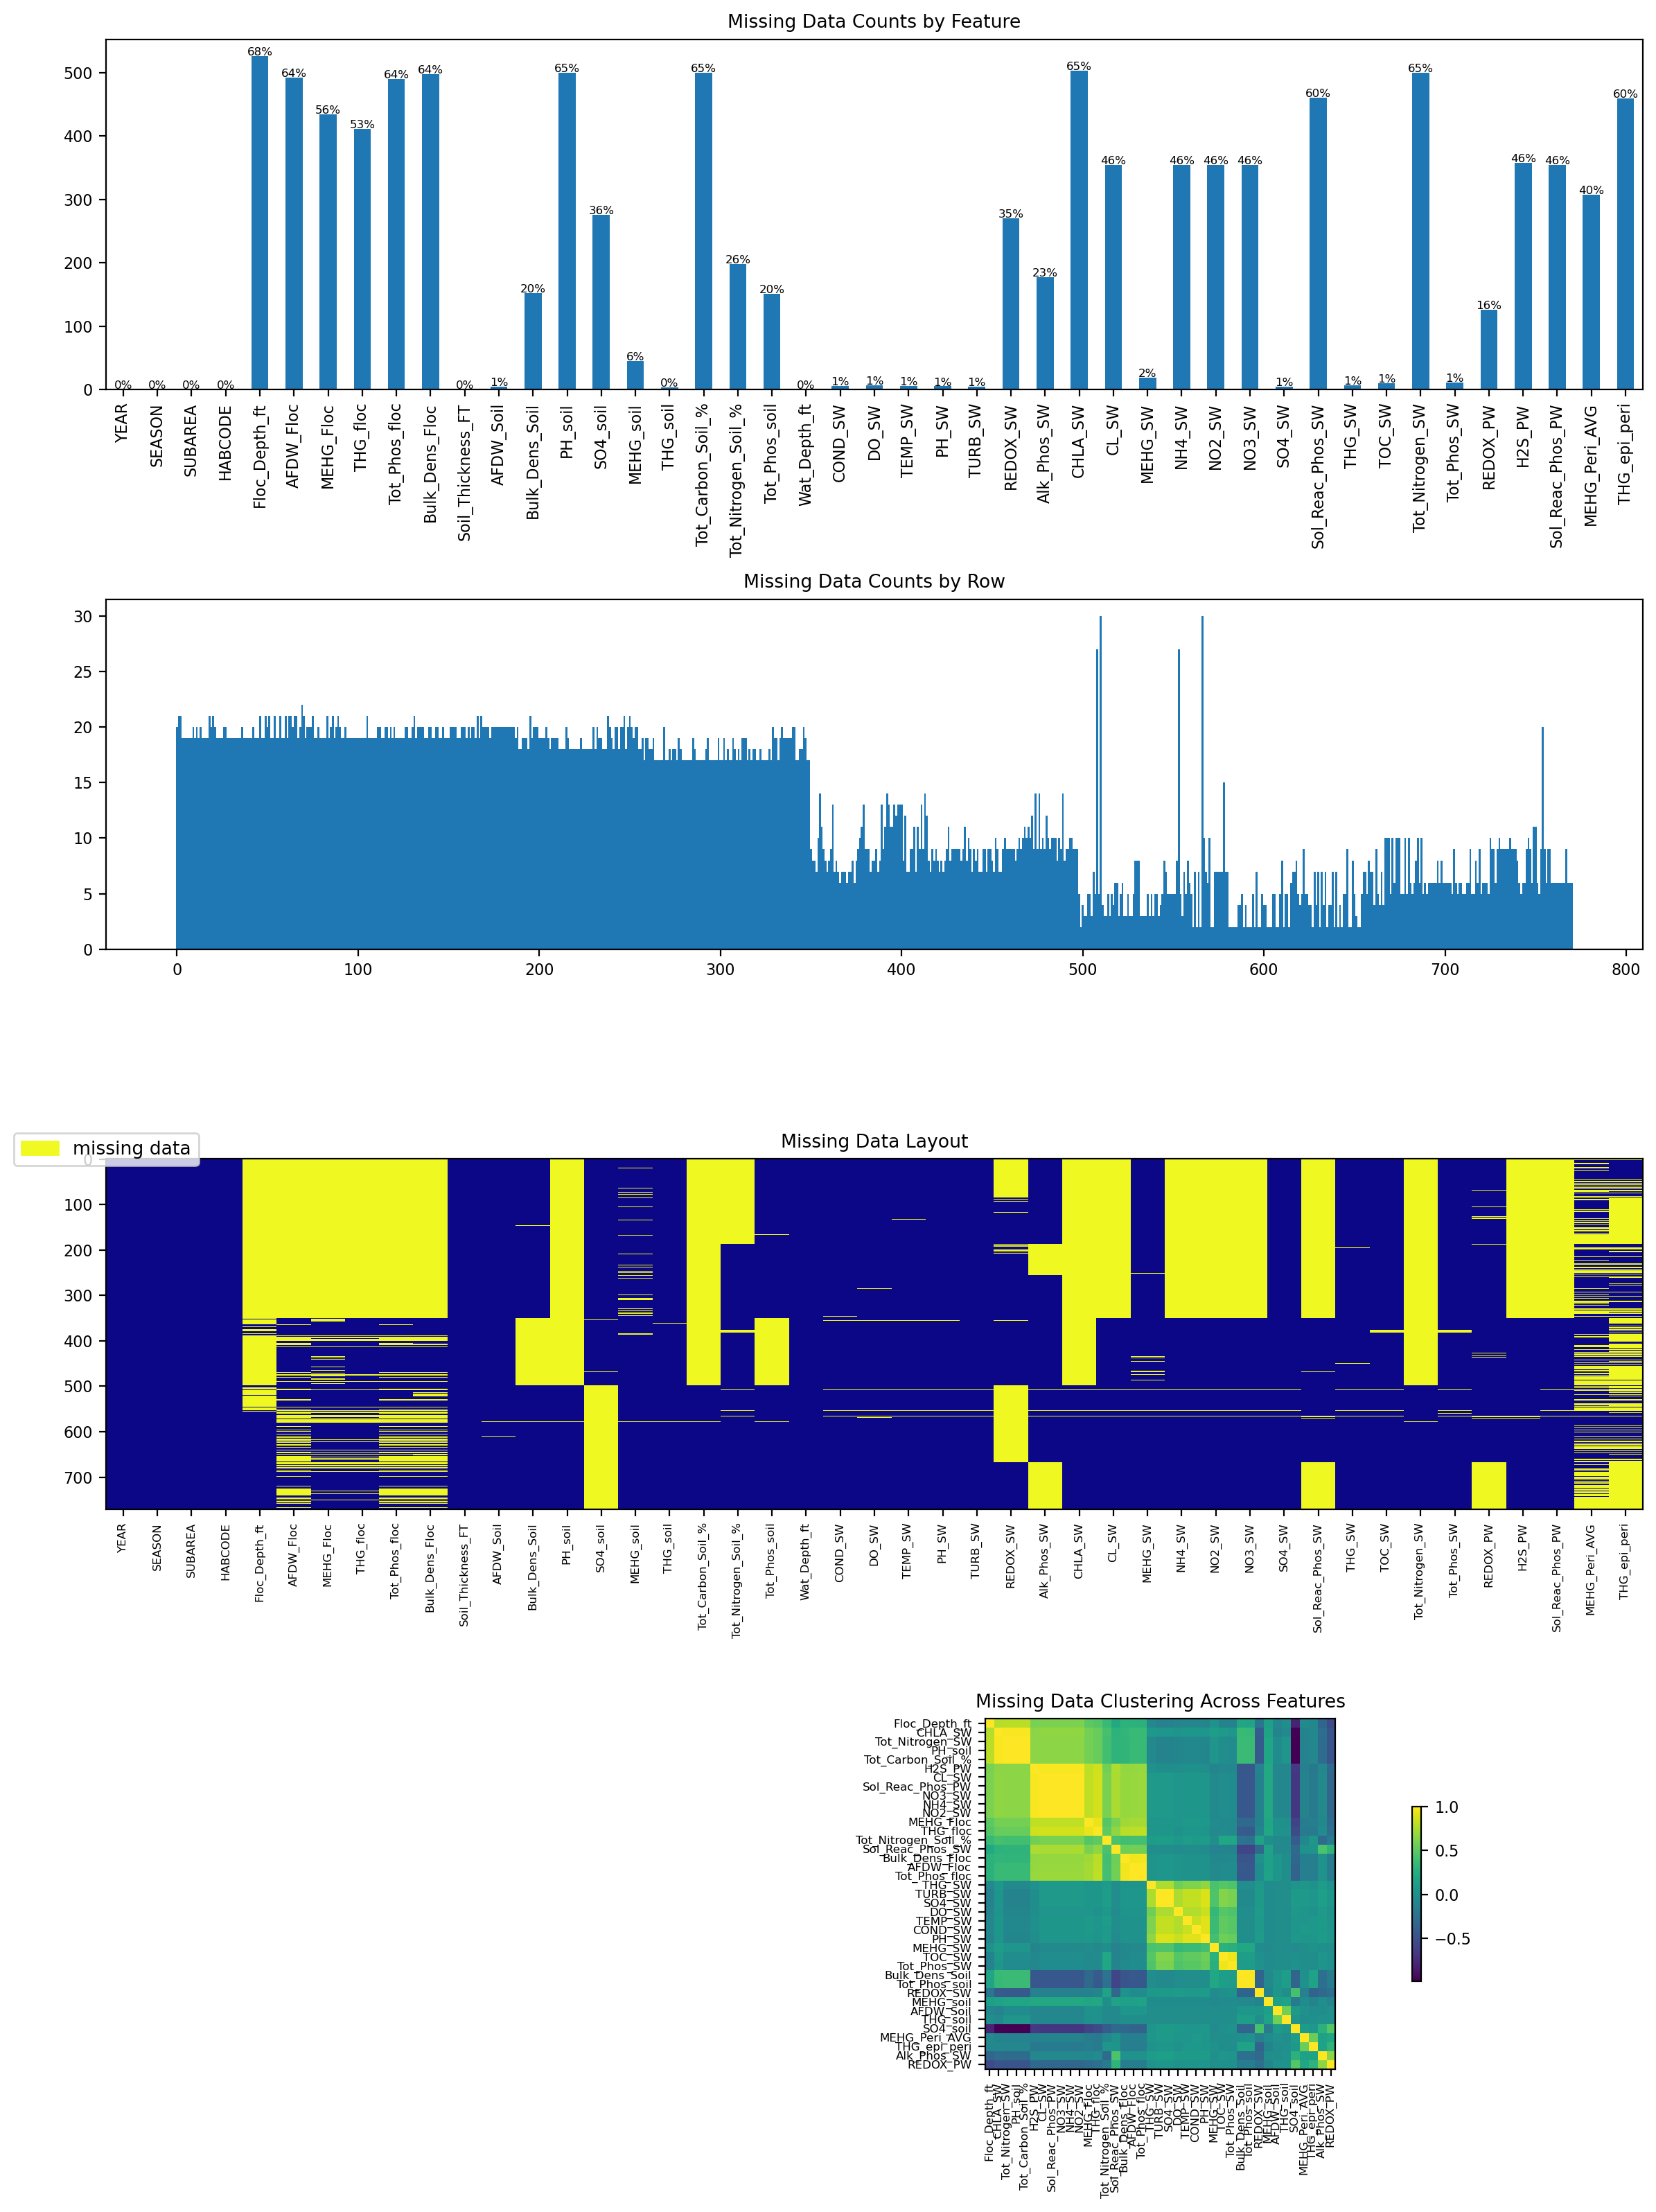

In [11]:
vbs.missingVals()

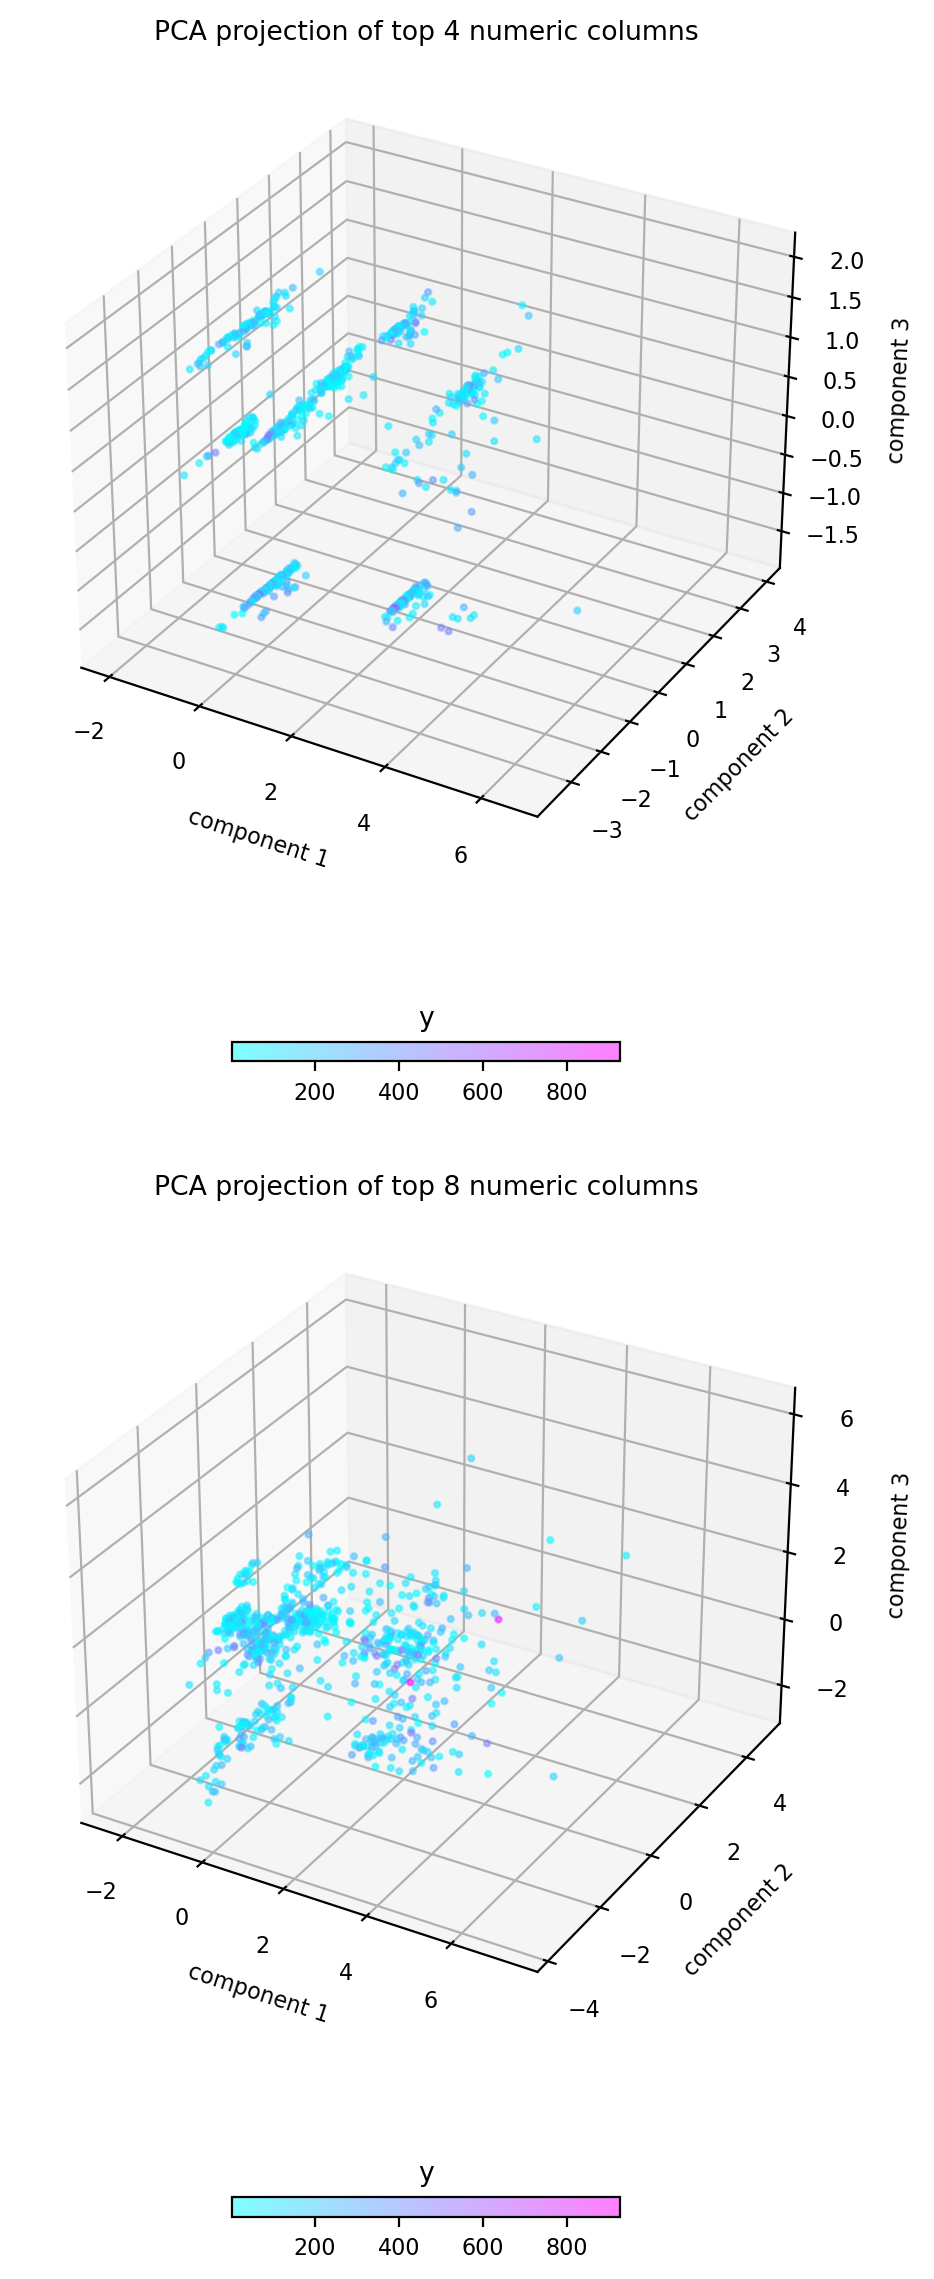

In [12]:
vbs.viewComponents(num_cols=[4,8],keep_cats=False)

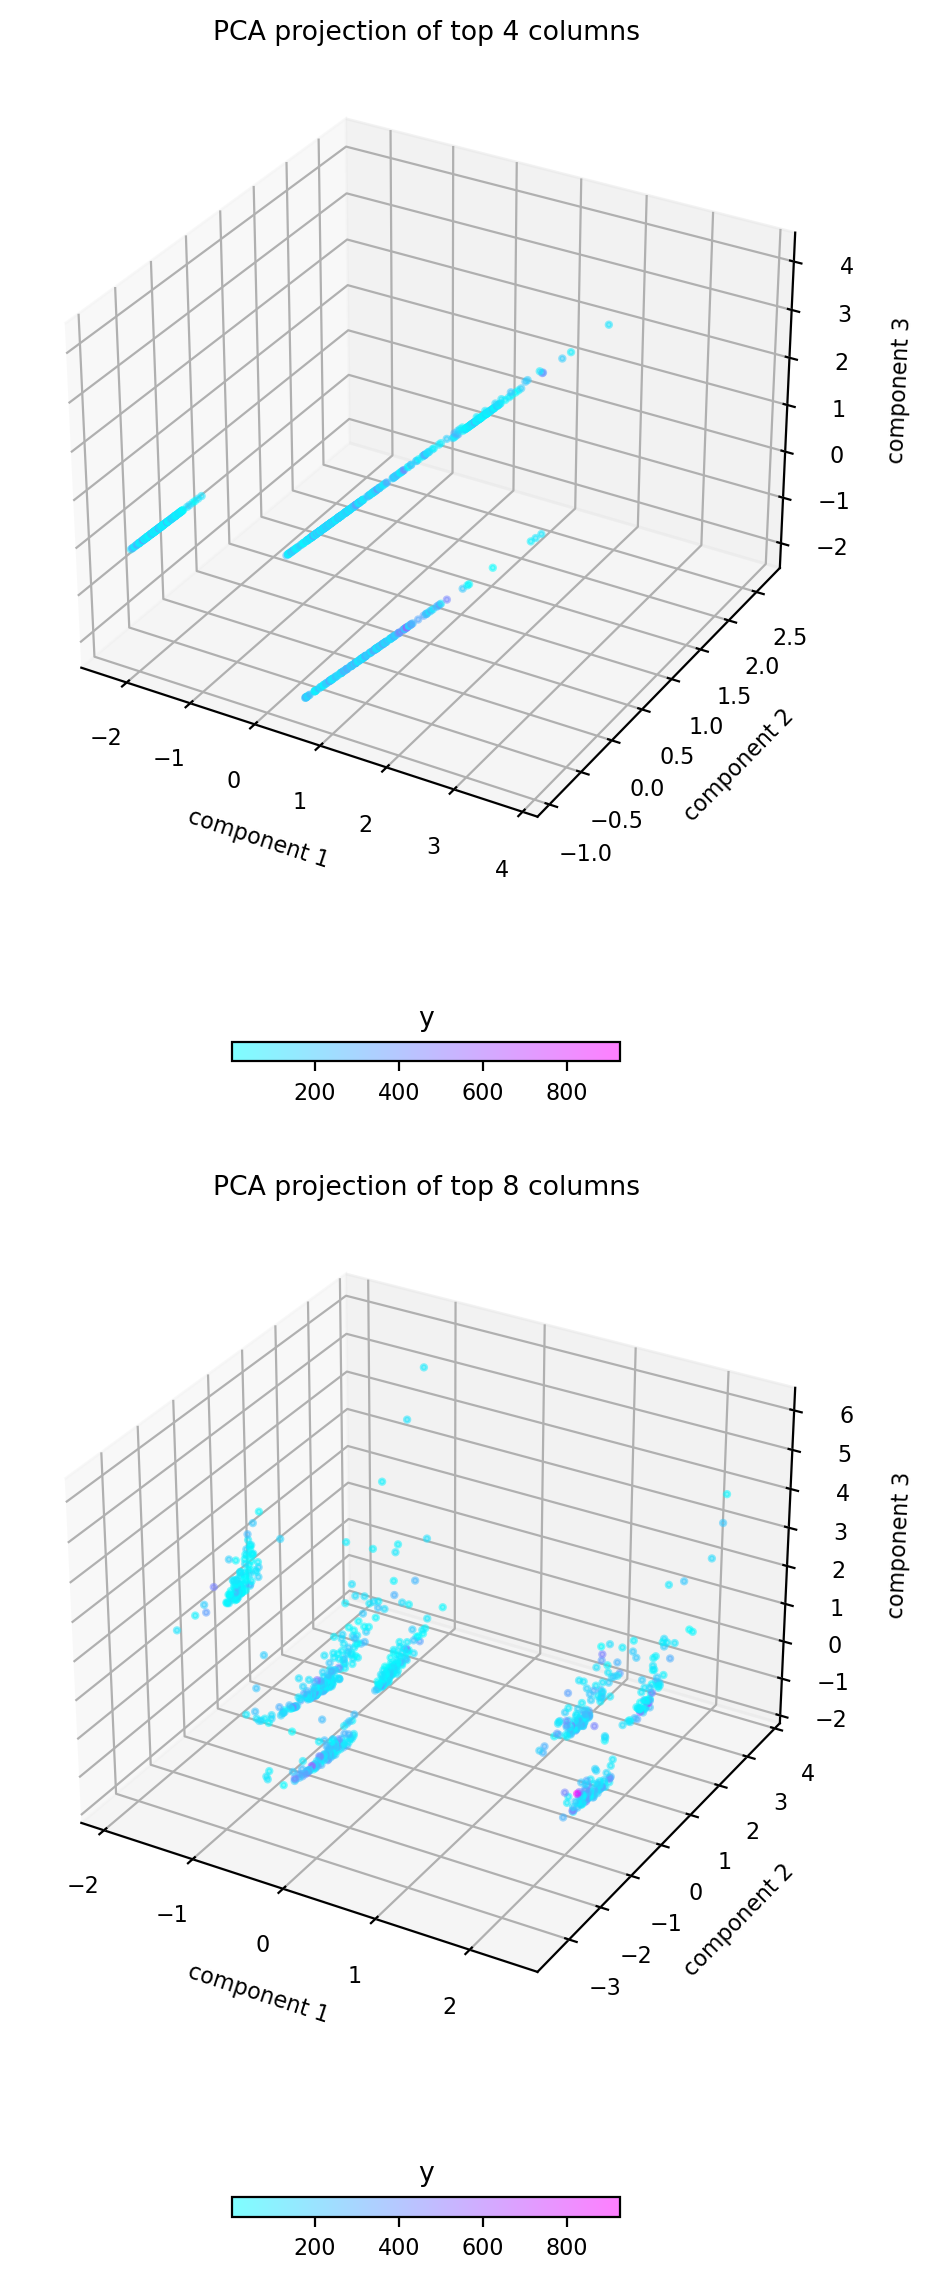

In [13]:
vbs.viewComponents(num_cols=[4,8],keep_cats=True)

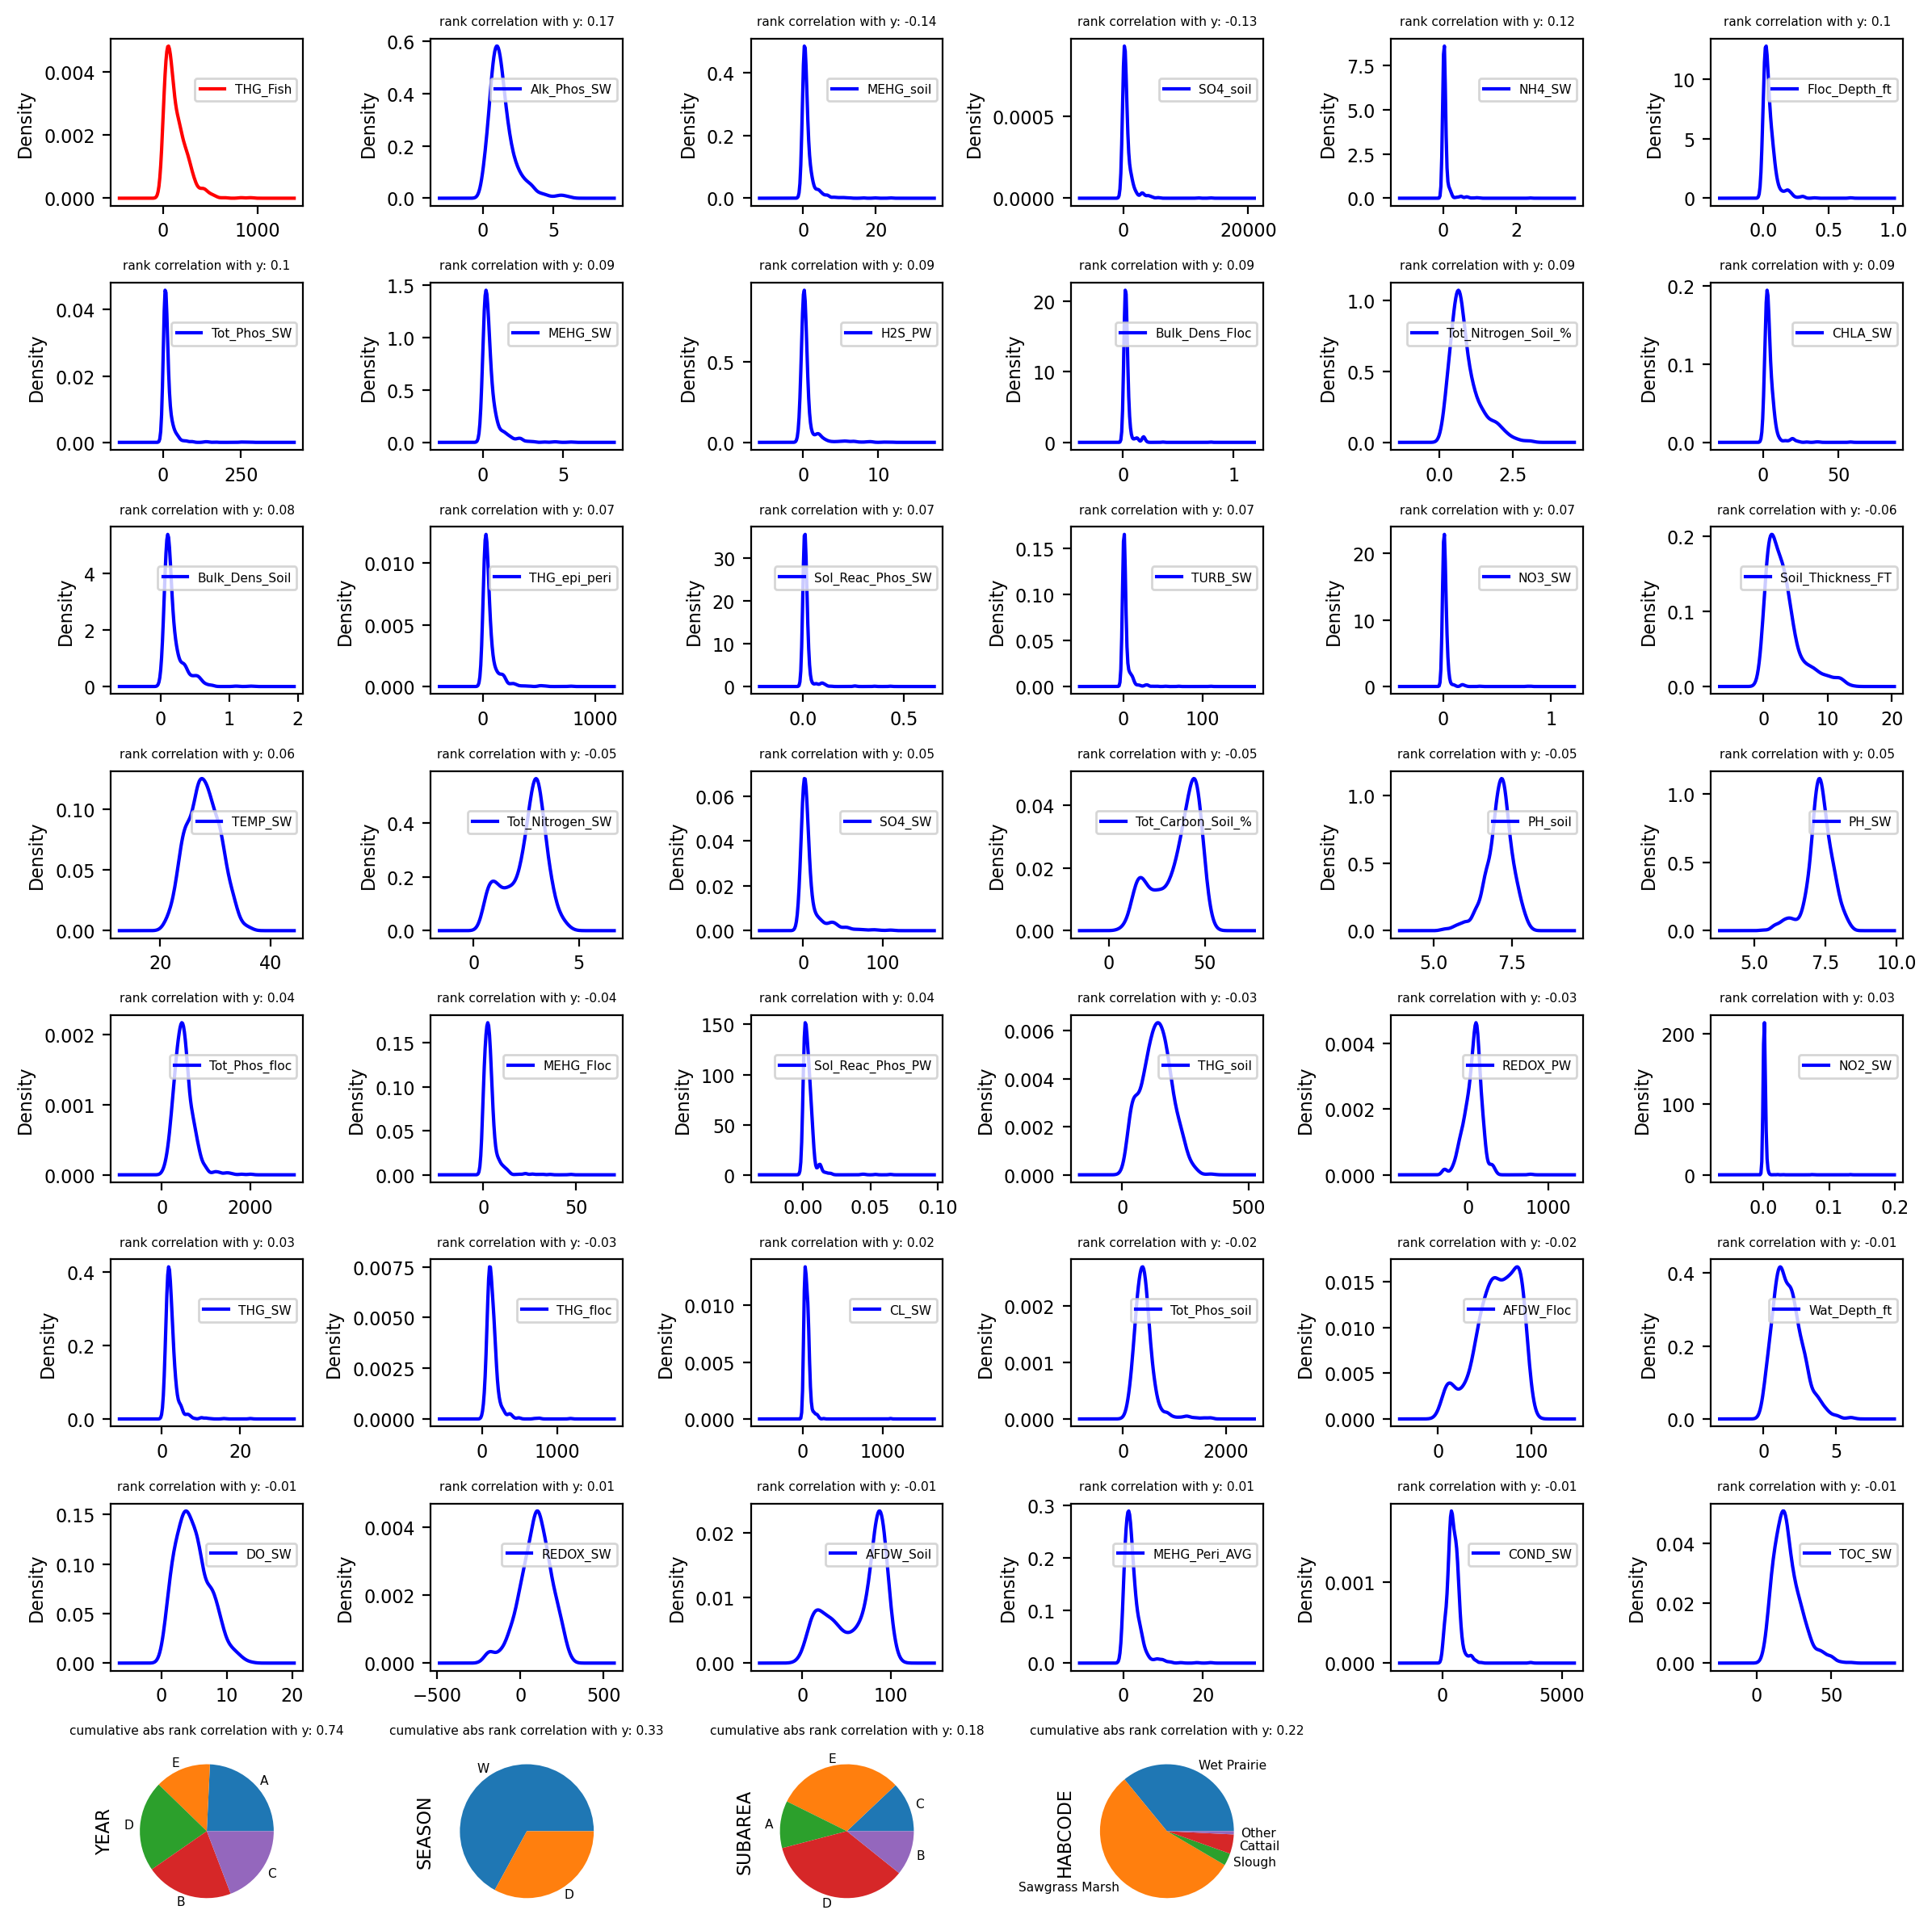

In [14]:
vbs.kernelDensityPie()

In [15]:
#vbs.hierarchicalDendrogram(linkage='ward',dist='pearsonr')

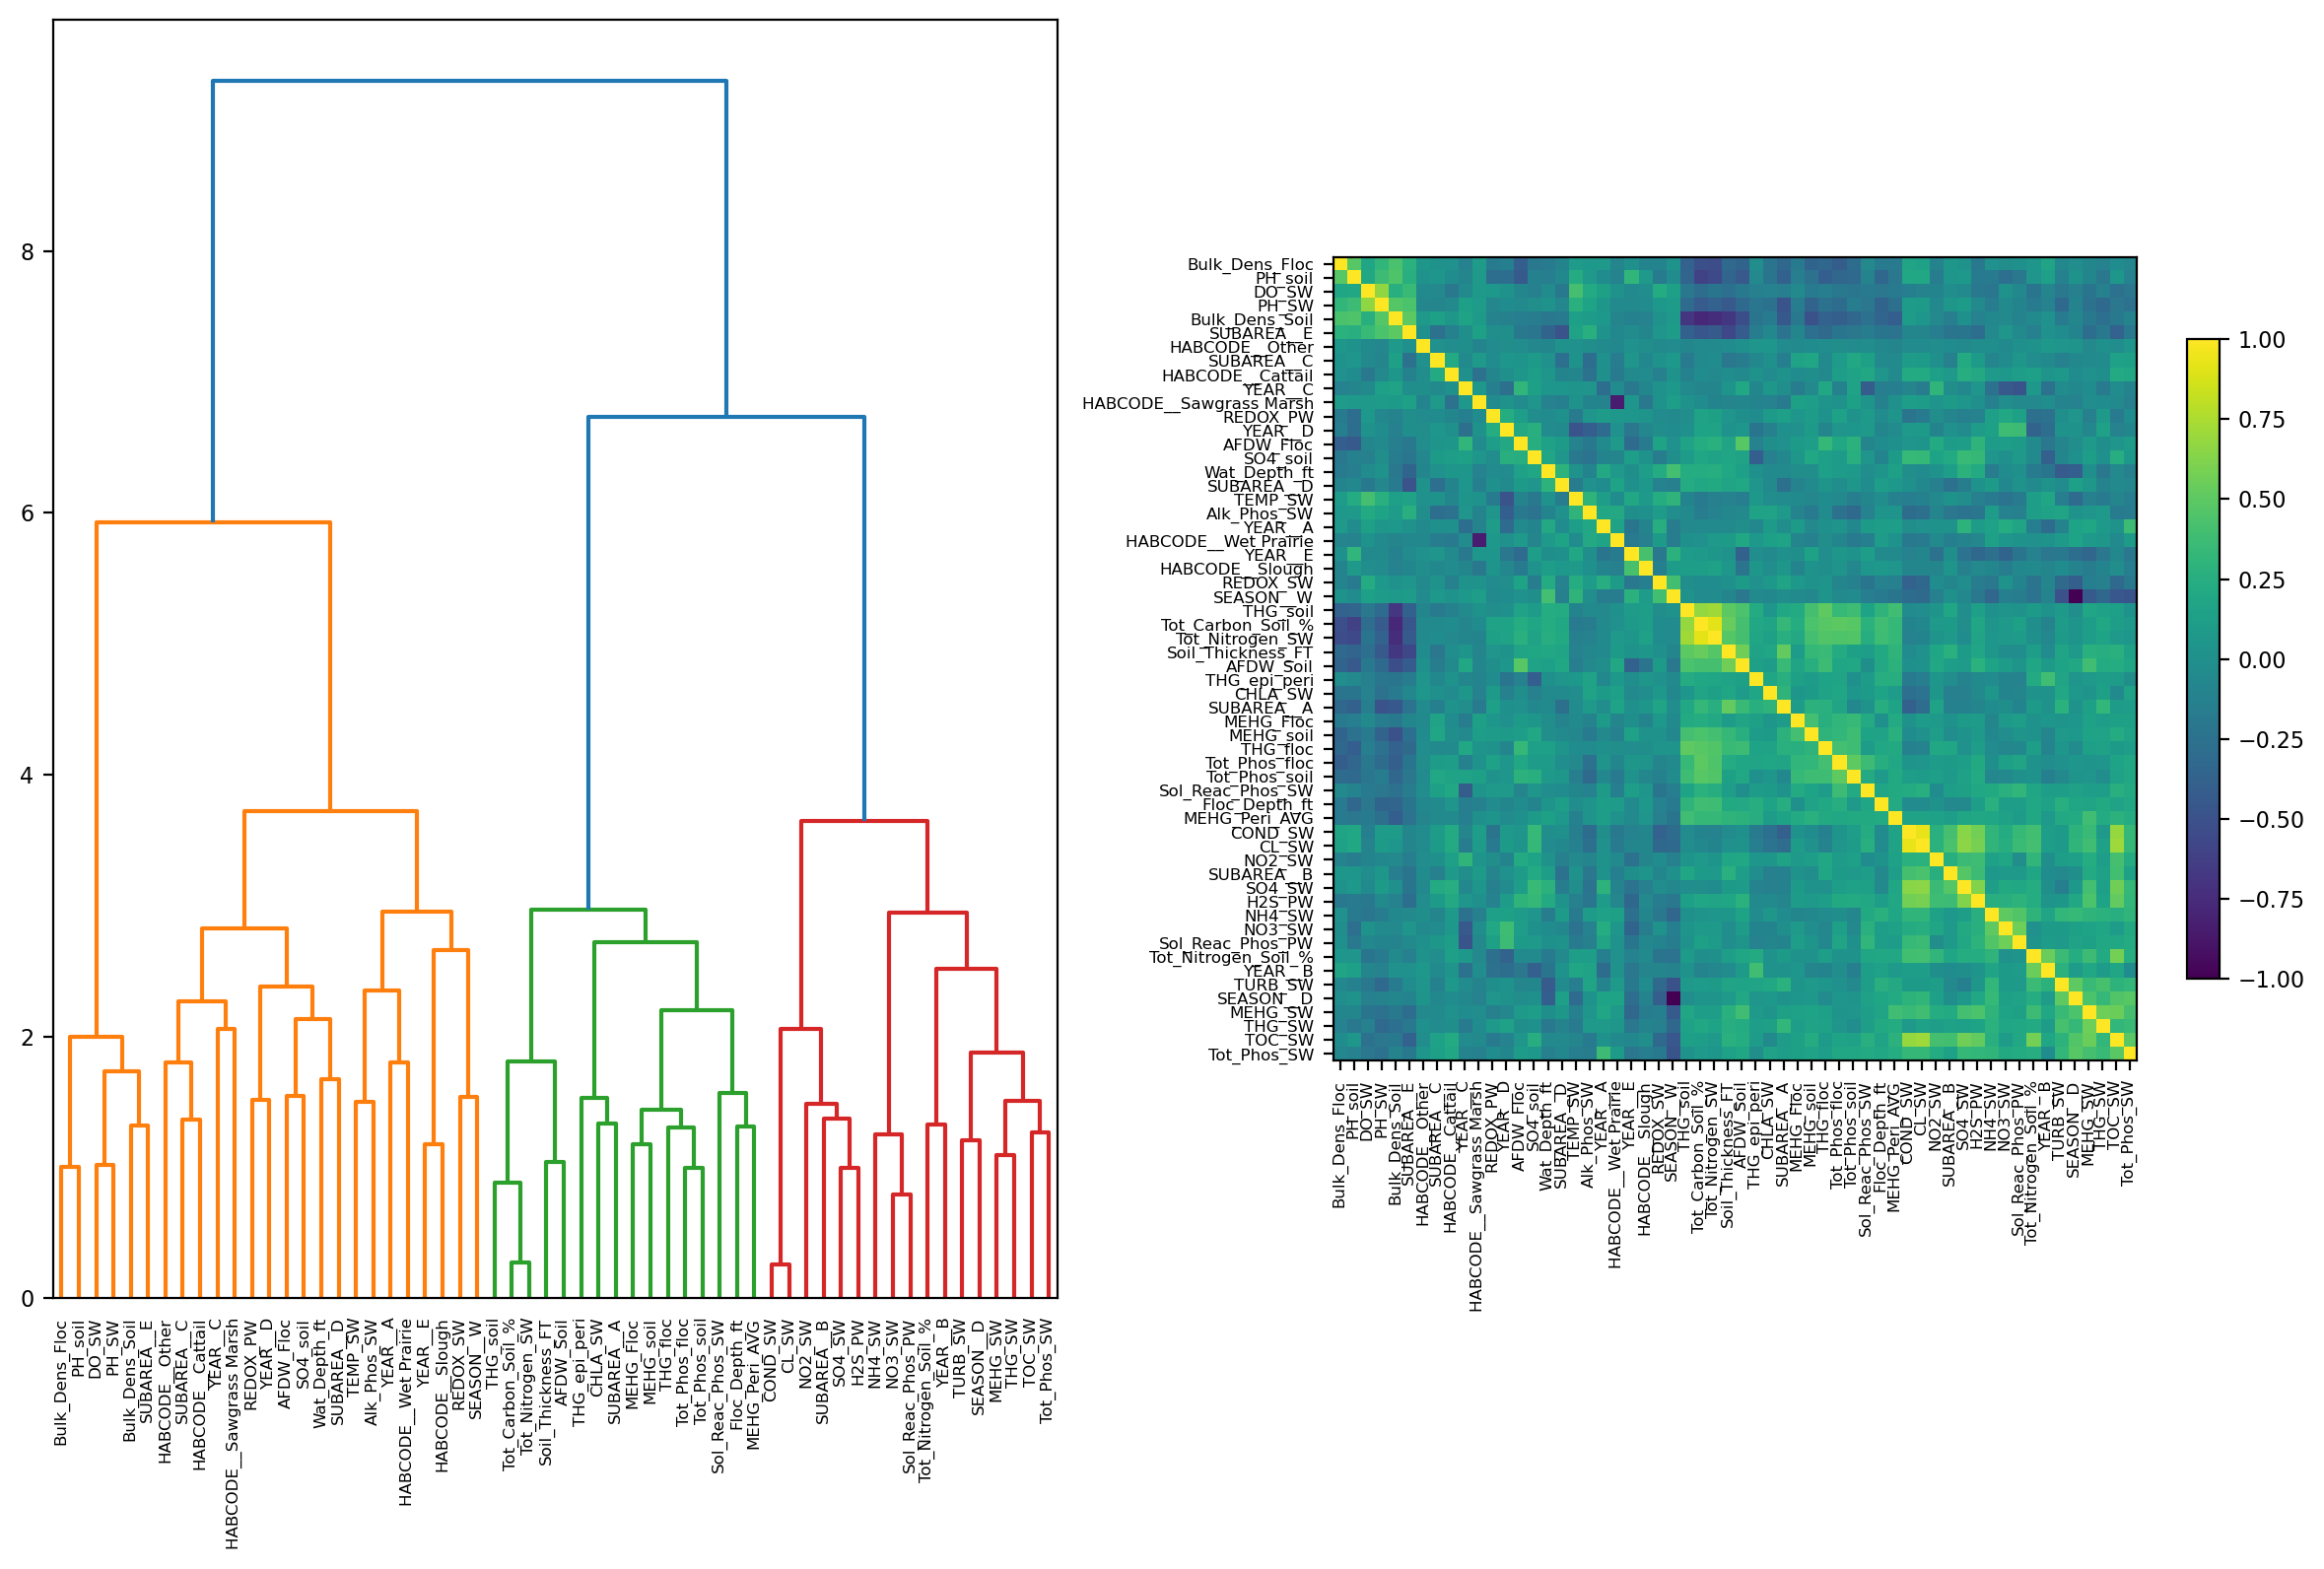

In [16]:
vbs.hierarchicalDendrogram(linkage='ward',dist='spearmanr')

# VB web
#### Machine Learning Pipelines
---

#### What is a Pipeline?
- From the [Sci-Kit Learn User Guide](https://scikit-learn.org/stable/modules/compose.html#pipeline)
 - > chain multiple estimators into one
 - > convenience and encapsulation
 - > joint parameter selection
 - > safety

#### Basic Pipeline Components

 1. Preparation
  - Imputation (KNN or Mean)
  - Categoric to Numeric Data
 2. Feature Engineering
  - Drop Zero Variance
  - Feature Selection (e.g., LASSO or K-Best)
  - Create Interactions, Higher-Order Polynomials
  - Reduce Dimensionality (e.g., PCA)
 3. Estimation
  - e.g., Linear Regression or Gradient Boosting or Support Vector or Stacking

#### K-Fold Cross Validation for Nested Inference
 - Cawley, G.C. and Talbot, N.L., 2010. On Over-Fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation. The Journal of Machine Learning Research, 11, pp.2079-2107. 
 - Hastie, T., Tibshirani, R., & Friedman, J. 2017. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. ([Second Edition, corrected 12th printing with table of contents](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12_toc.pdf )) Springer Series in Statistics.  
 - Hawkins, D. M., Basak, S. C., & Mills, D. 2003. Assessing Model Fit by Cross-Validation. Journal of Chemical Information and Computer Sciences, 43(2), 579-586. 
 - Guyon, I., Saffari, A., Dror, G. and Cawley, G., 2010. Model Selection: Beyond the Bayesian/Frequentist Divide. Journal of Machine Learning Research, 11(1). 

![cross validation data folding and splitting detail](images/cv_data_splitting.jpg)

![pipeline schematic](images/pipeline_anatomy.jpg)

![pipeline schematic](images/life_stages_detail.jpg)

##### specify internal CV for hyper-parameter tuning

In [17]:
inner_cv_dict={
    'cv_reps':1,
    'cv_folds':5,
    'cv_strategy':('quantile',5)} # ensure each fold has y values from each quantile
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

#### A look at inner cross validation
![inner cross validation detailed view regression pipeline](images/inner_cv_detail_reg.jpg)

#### inner cross validation for the stacking regressor
![stacking regressor inner cross validation diagram](images/stacking_regressor_1.jpg)

##### specify data preparation

In [18]:
prep_dict={
    'cat_approach':'together', # imputation is over all variables after one-hot-encoding
    'impute_strategy':'IterativeImputer', # python implementation of MICE: Multivariate Imputation by Chained Equations in R”
    'cat_idx':vbhelper.cat_idx # keep track of the categorical variables
    }
pipe_dict={} # the pipeline setup will go here

##### specify pipelines

###### setup keyword arguments for pipelines

In [19]:
pipe_kwargs={
    'do_prep':not vbhelper.run_stacked, # the stacking regressor will do imputation if run_stacked==True
    'prep_dict':prep_dict,
    'inner_cv':inner_cv,
    'cat_idx':vbhelper.cat_idx,
    'float_idx':vbhelper.float_idx,
    'bestT':False # if true, test each covariate for optimal transformation 
    }

##### add a gradient boosting regressor pipeline
![gradient boosting regressor pipeline life stages detailed](images/gbr_stages_detail.jpg)

In [20]:
from vb_estimators import GBR

gbr_kwargs=pipe_kwargs.copy()
gbr_kwargs['est_kwargs']={
    'n_estimators':[64,128],
    'max_depth':[2,3]
    }
pipe_dict['gbr']={
    'pipe':GBR,
    'pipe_kwargs':gbr_kwargs
    }

##### create a cross-validated lasso linear regression pipeline

In [21]:
from vb_estimators import  L1Lars

l1_kwargs=pipe_kwargs.copy()
l1_kwargs['max_n_alphas']=500 # alpha is the only hyper-parameter
pipe_dict['lassolars']={
    'pipe':L1Lars,
    'pipe_kwargs':l1_kwargs
    }

##### and a support vector machine regressor using the rbf kernel

In [22]:
from vb_estimators import RBFSVR

rbf_kwargs=pipe_kwargs.copy()
rbf_kwargs['gridpoints']=5 
pipe_dict['rbfSVR']={
    'pipe':RBFSVR,
    'pipe_kwargs':rbf_kwargs
    }

and finally add a pipeline that tests a few non-linear models

In [23]:
from vb_estimators import FlexiblePipe

nl_pipe_kwargs=pipe_kwargs.copy()
nl_pipe_kwargs['functional_form_search']=True
nl_pipe_kwargs['flex_kwargs']={'robust':True}
pipe_dict['nonlinear']={
    'pipe':FlexiblePipe,
    'pipe_kwargs':nl_pipe_kwargs
}

In [24]:
#and load the pipelines
vbhelper.setPipeDict(pipe_dict)
vbhelper.setModelDict()

In [25]:
from sklearn.model_selection import train_test_split
from time import time
X_train, X_test, y_train, y_test=train_test_split(X_df,y_df,test_size=0.7,random_state=5) #just for debugging

In [26]:
runtest=False
if runtest:
    for name,est in vbhelper.model_dict.items():
        start=time()
        print(name)
        est.fit(X_train,y_train)
        print('train R2:',est.score(X_train,y_train))
        if not X_test is None:print('test R2:',est.score(X_test,y_test))
        end=time()
        print(f'runtime:{(end-start)/60} min.\n')

In [27]:
if vbhelper.run_stacked and runtest:
    mp=vbhelper.model_dict['multi_pipe']
    fitted_ipipe_dict=mp.build_individual_fitted_pipelines()
    for p_name,p in fitted_ipipe_dict.items():
        print(f'{p_name} scored: {p.score(X_test,y_test)}')


# VB web
## Small Data Procedure
### Model Phase
---
#### Task 1: Model Selection and Testing/Validation
##### Stacking Regressor is selected
##### Evaluate the accuracy of the machine learning pipelines

In [28]:
vbhelper.runCrossValidate(try_load=True)

jhash:  e22ce374a56f407c8198551233cc94a9
existing cv_results loaded


In [29]:
vbhelper.buildCVScoreDict()
vbhelper.saveCVResults()

cross validation results saved to project_cv_results.json


### Plot the results

In [30]:
from vb_plotter import VBPlotter
plotter=VBPlotter()

with open('project_cv_results.json','rb') as f:
    cv_results_and_scores=json.load(f)
plotter.setData(cv_results_and_scores)

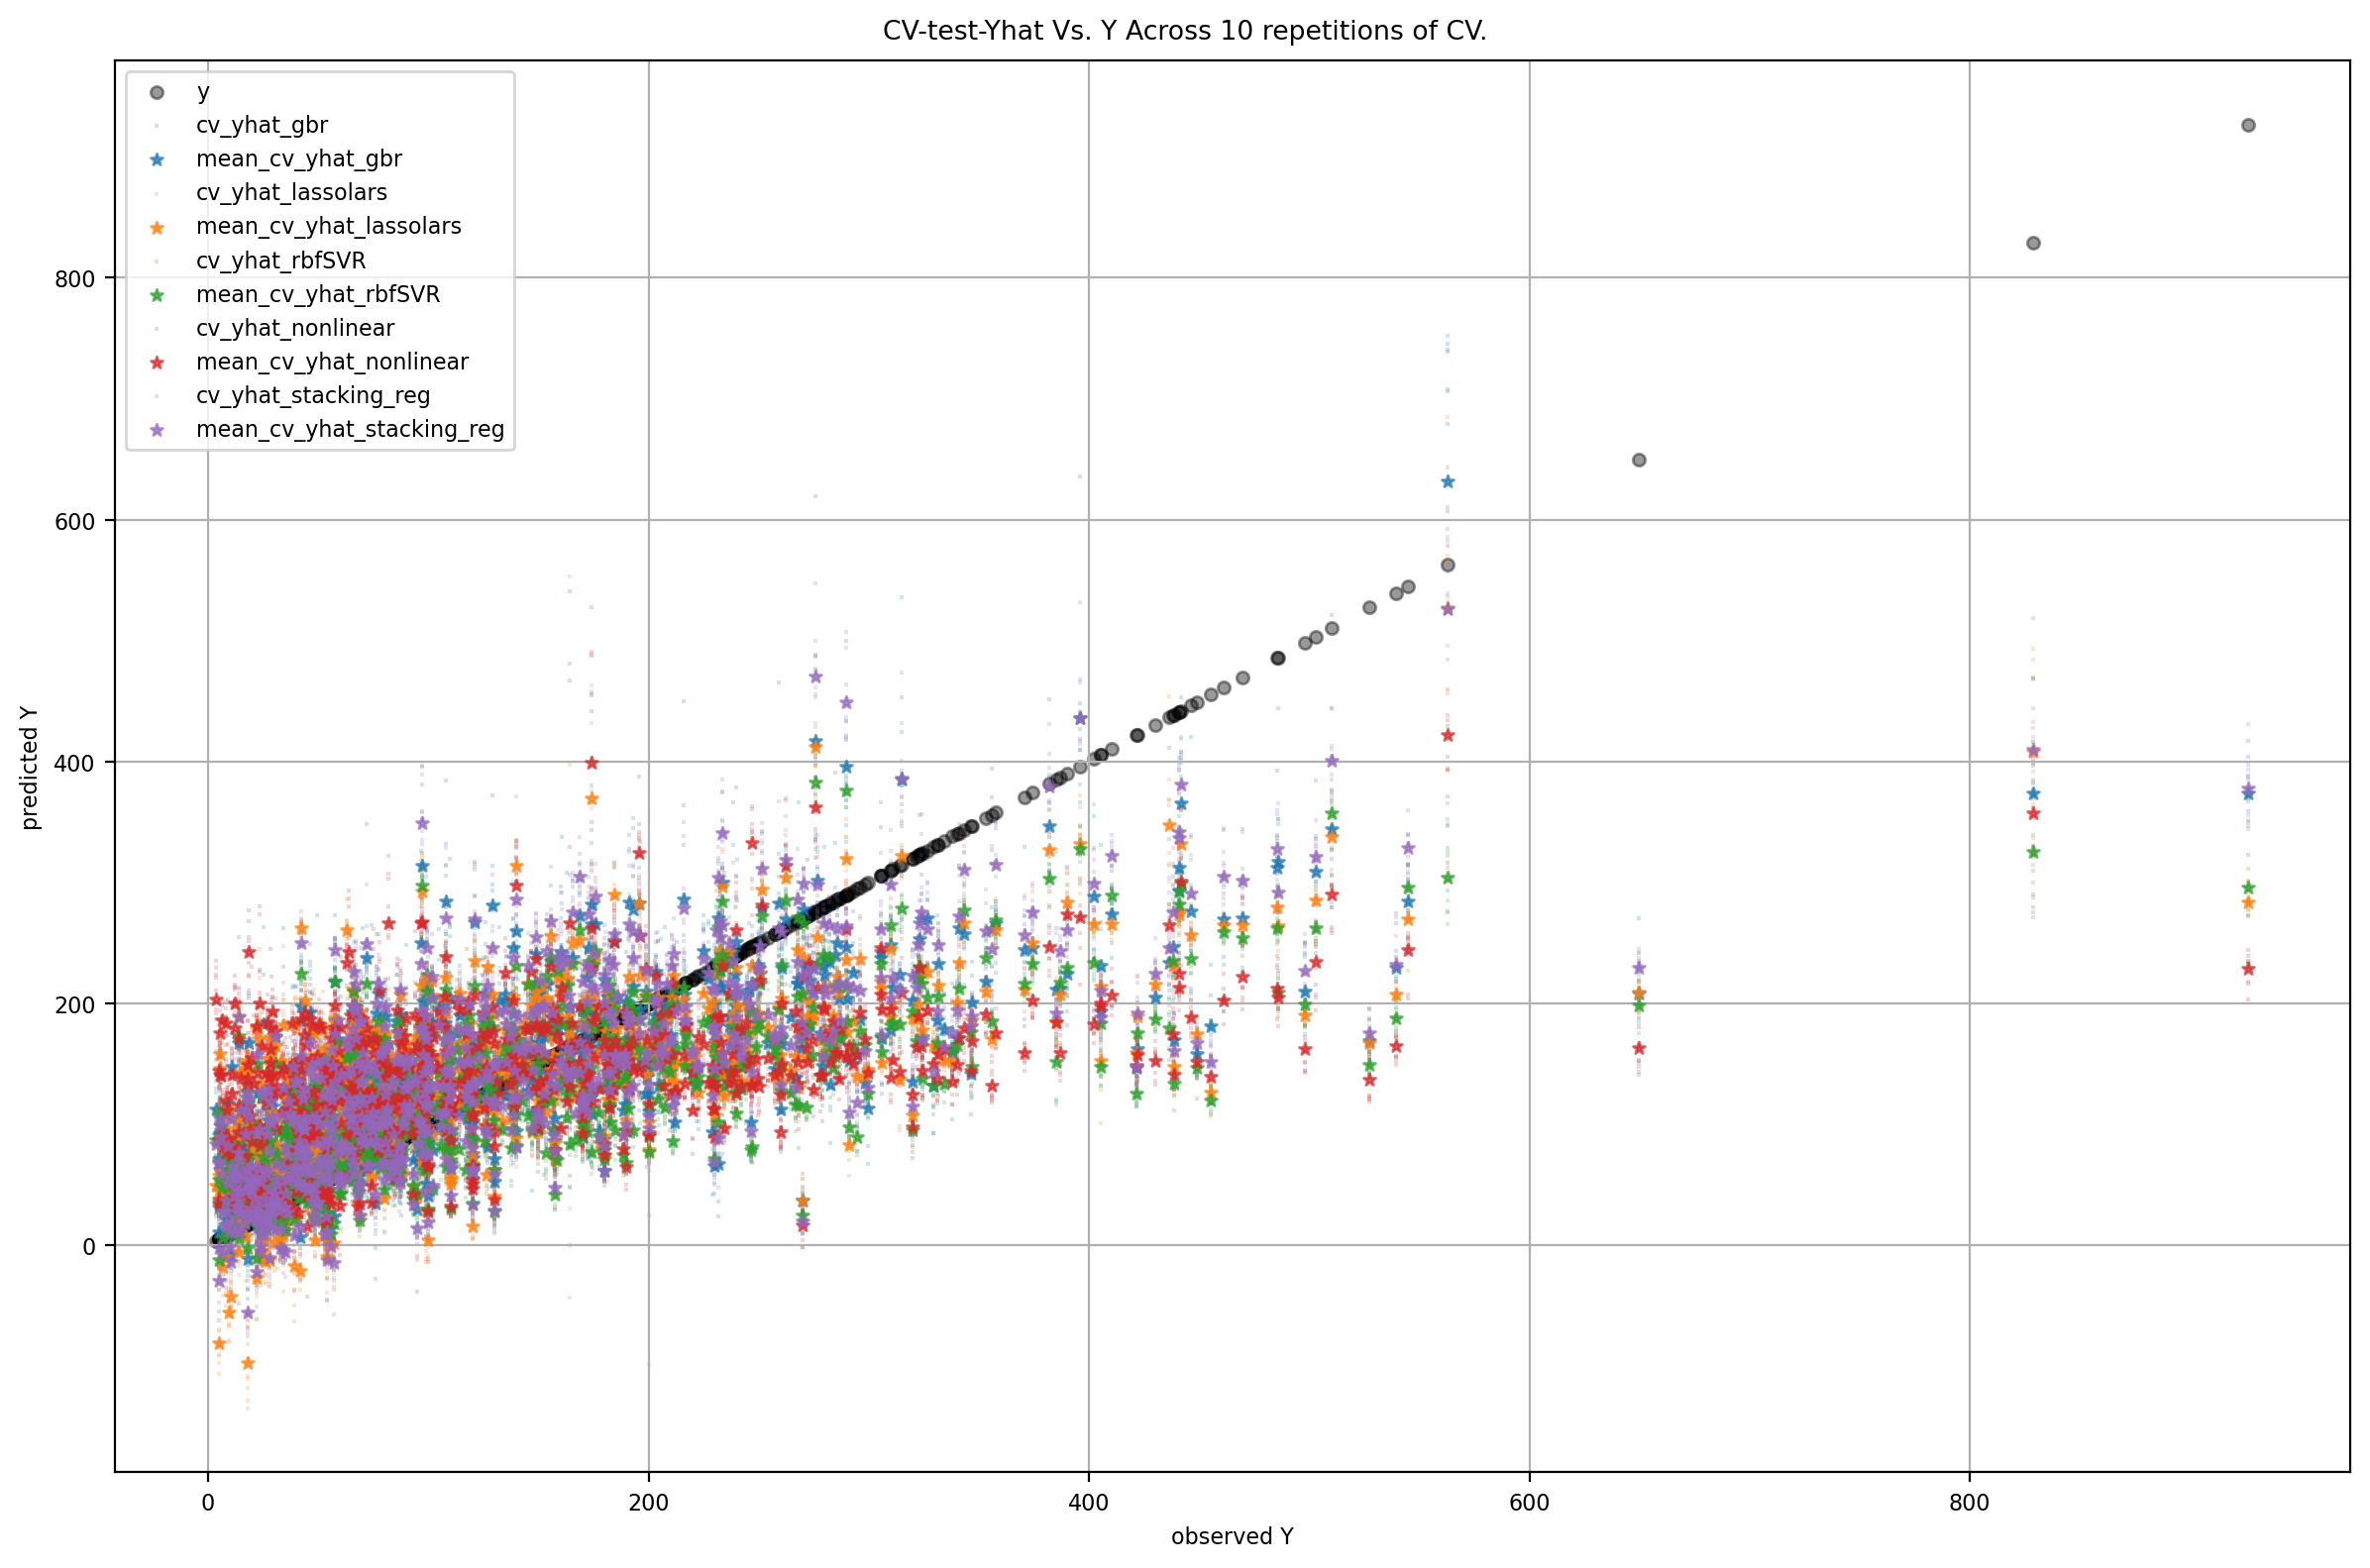

In [31]:
plotter.plotCVYhatVsY(single_plot=True,include_all_cv=True)

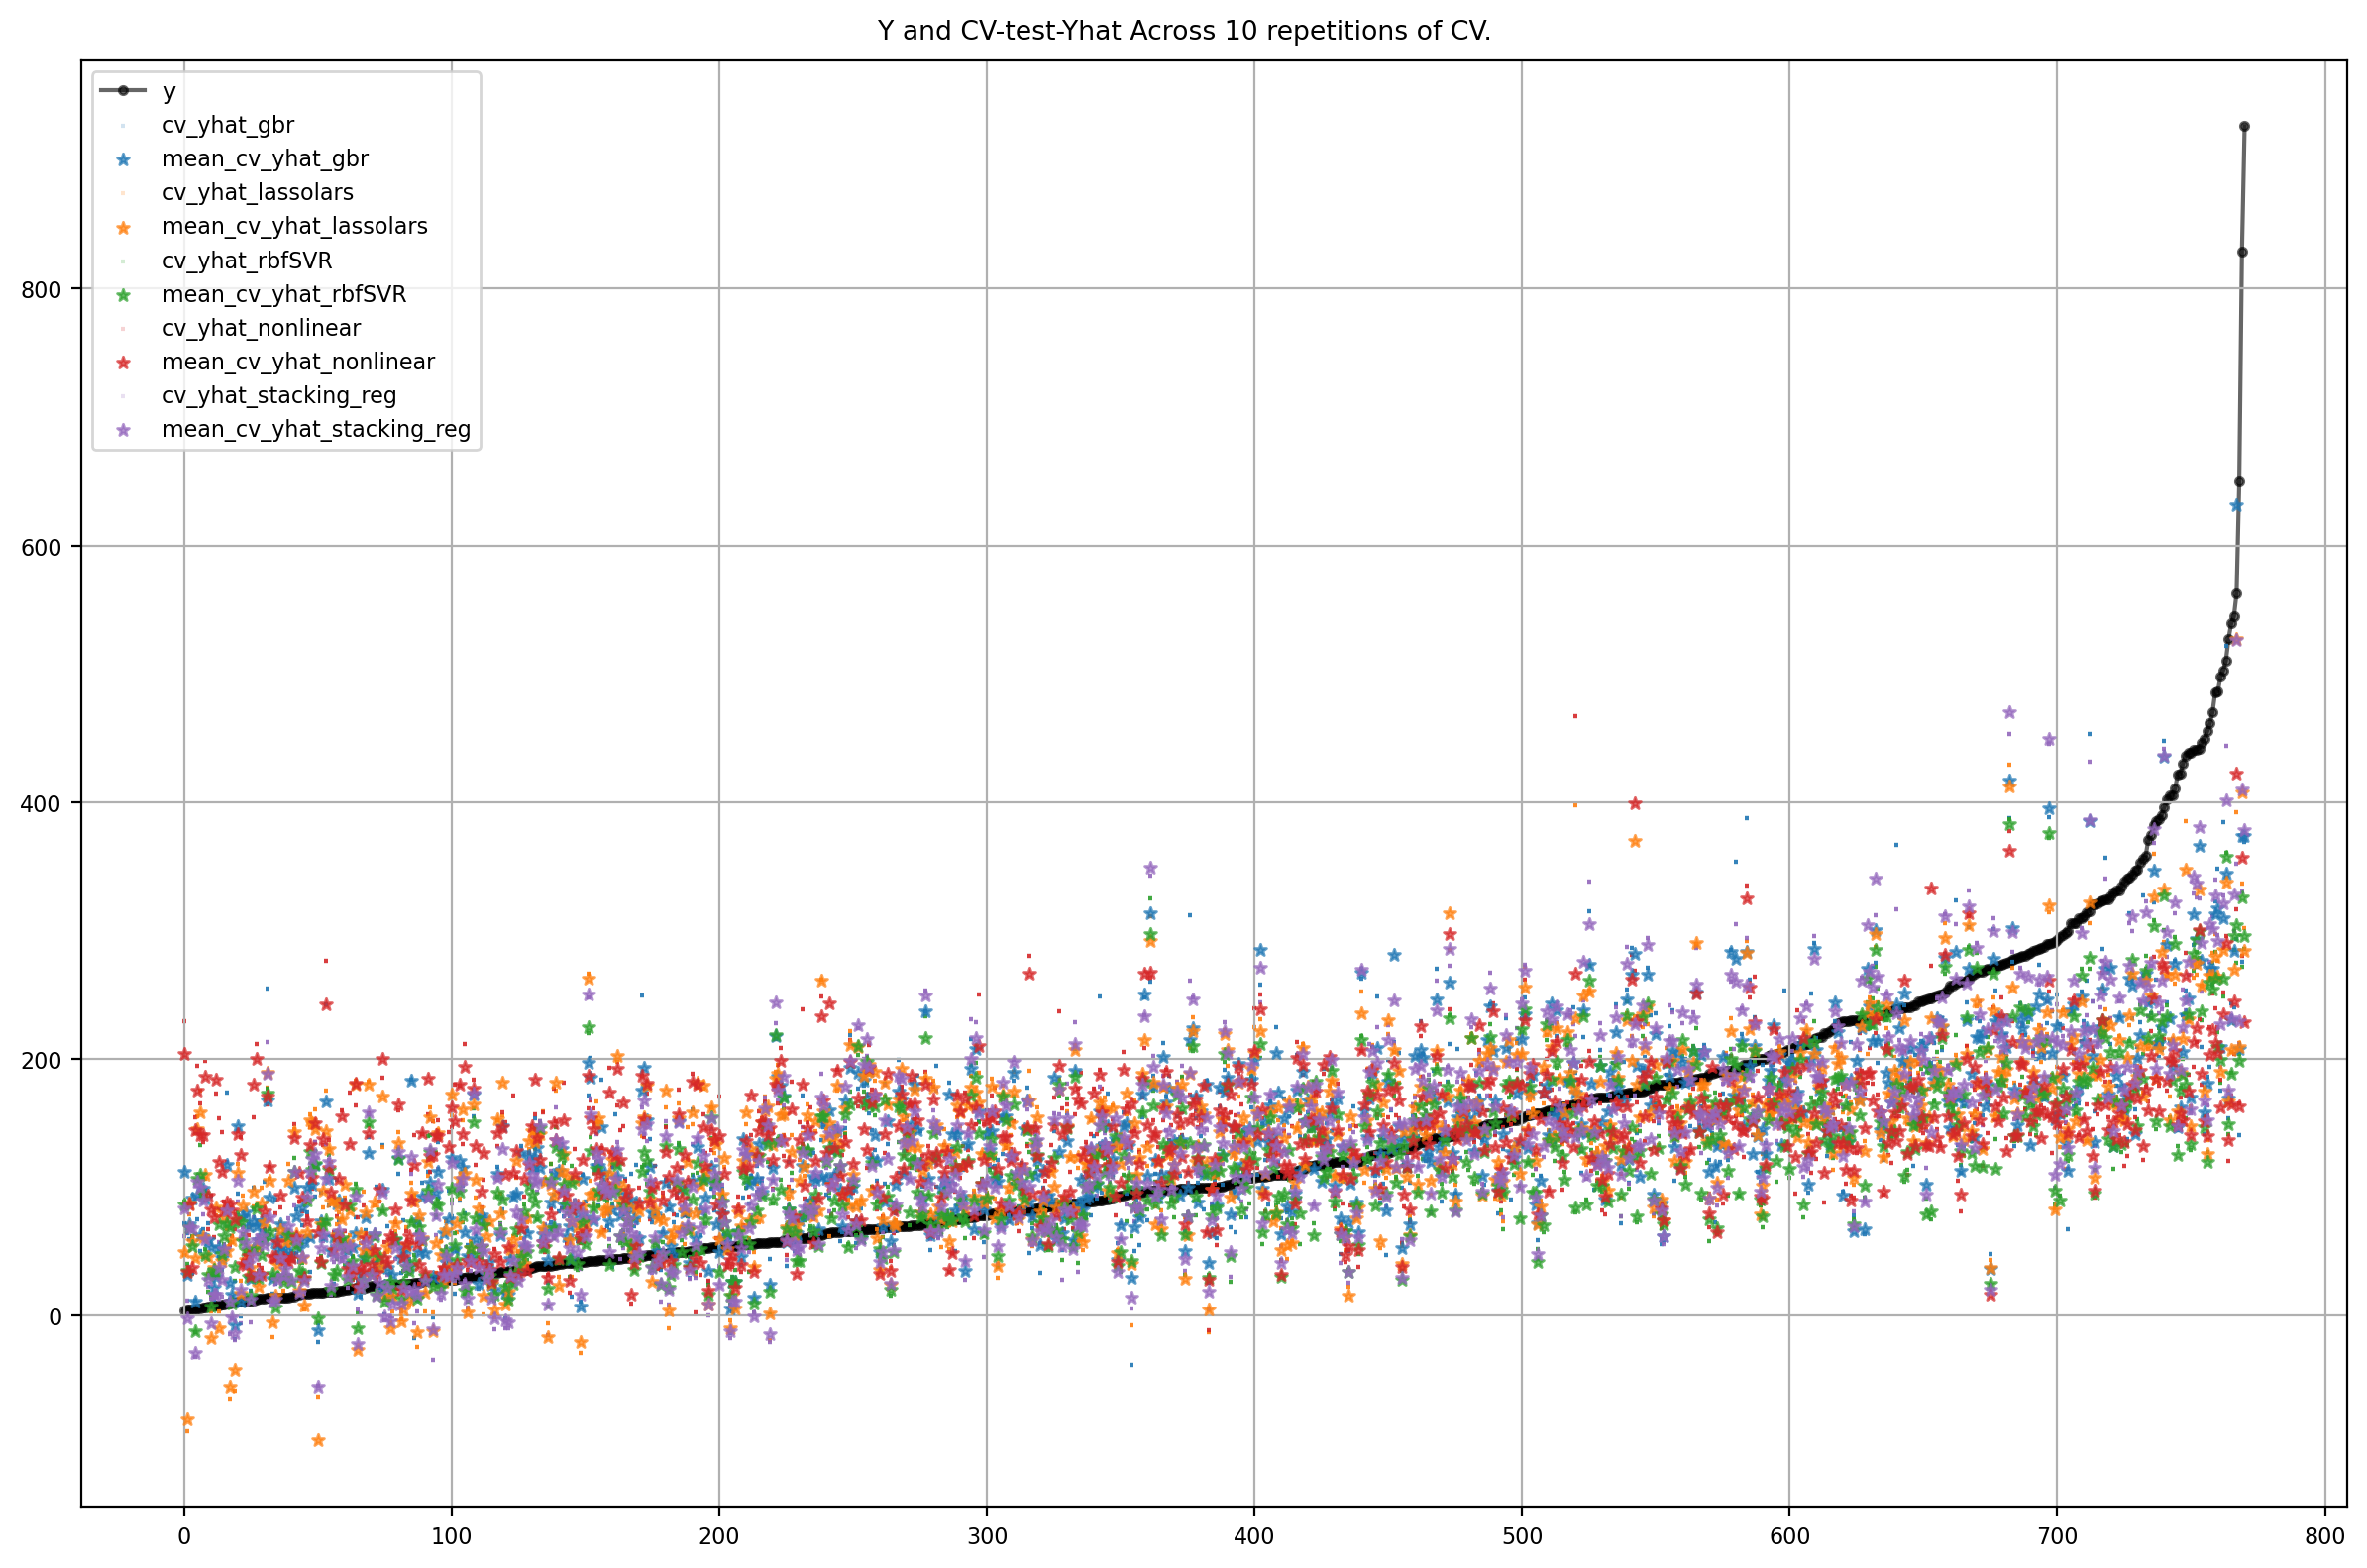

In [32]:
plotter.plotCVYhat(single_plot=True,include_all_cv=True) #add option to use original row order instead of sort

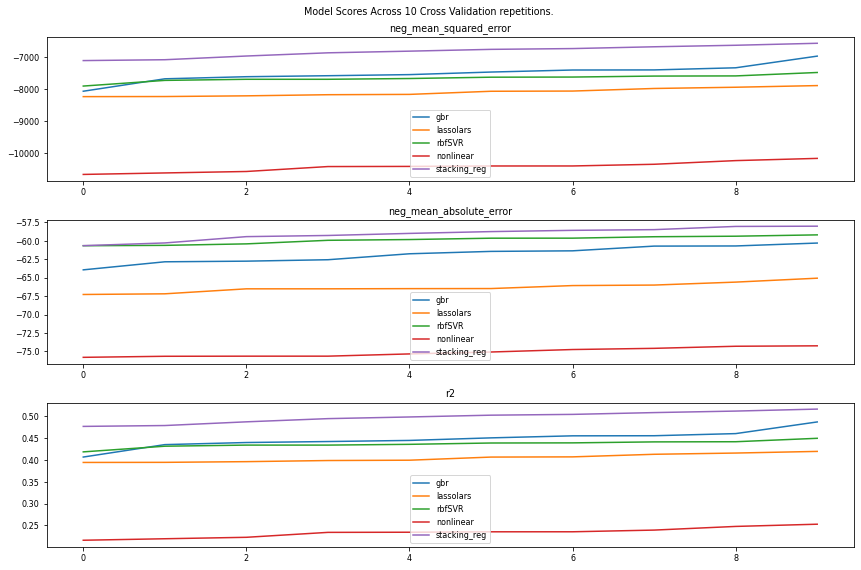

In [33]:
plotter.plotCVScores(sort=1)

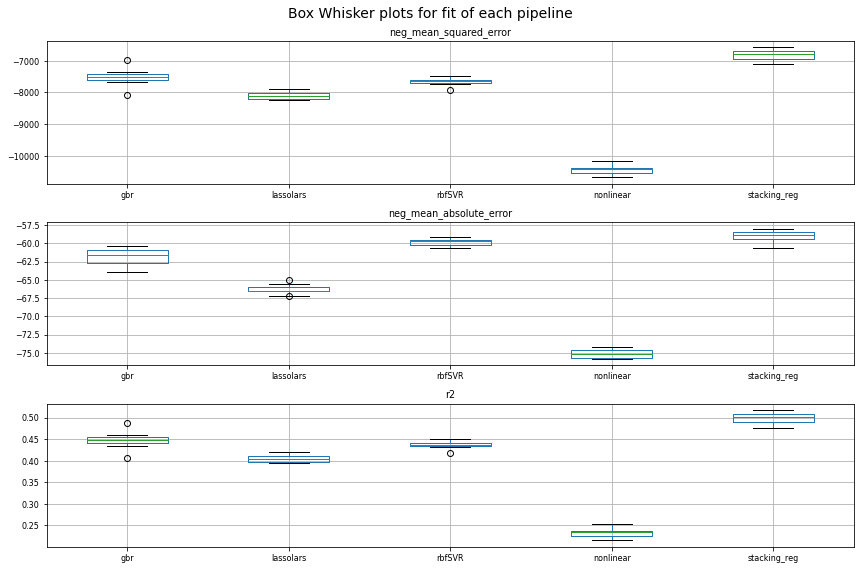

In [34]:
plotter.plotBoxWhiskerCVScores()

# VB web
## Small Data Procedure

#### Task 2: Train the Final, Predictive Model
##### Using all of the data

In [35]:
vbhelper.refitPredictiveModels(selected_models=['stacking_reg'])

predictive models loaded from stash/predictive_model-e9c8c480aea816f0e60de7a913406c65.pkl


# VB web
## Small Data Procedure
### Predict Phase
Finally we are ready to use the predictive model that we just estimated.


In [36]:
vbhelper.predictandSave(X_predict)

AttributeError: 'list' object has no attribute 'to_numpy'

In [ ]:
with open('project_prediction_results.json', 'r') as f:
    project_prediction_results=json.load(f)
plotter.setPredictData(project_prediction_results)

In [ ]:
p_kwargs=dict(single_plot=True, include_all_cv=True,
              ypredict=True,cv_ypredict=True,estimators='selected')
plotter.plotCVYhatVsY(**p_kwargs)

#### And redraw the plots with the known values of y as vertical lines

In [ ]:
plotter.plotCVYhatVsY(**p_kwargs,true_y=y_predict)

#### Or we can predict each observation separately

In [ ]:
plotters=[VBPlotter() for _ in range(predict_n)]
for p in plotters: p.setData(cv_results_and_scores)
for i in range(predict_n): plotters[i].setPredictData(project_prediction_results,loc_row=y_predict.index[i])
for i in range(predict_n): plotters[i].plotCVYhatVsY(**p_kwargs,true_y=y_predict.loc[[y_predict.index[i]]])